In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# !dir "../csv/round-1-island-data-bottle"

RELATIVE_DIR = "../csv/round-1-island-data-bottle"
ROUND = 1

In [3]:
prices_df_byDay = {}
trades_df_byDay = {}

for day in [-2, -1, 0]:
    prices_df_byDay[day] = pd.read_csv(f"{RELATIVE_DIR}/prices_round_{ROUND}_day_{day}.csv", delimiter=";")
    trades_df_byDay[day] = pd.read_csv(f"{RELATIVE_DIR}/trades_round_{ROUND}_day_{day}_nn.csv", delimiter=";")

In [4]:
prices = prices_df_byDay[-1][lambda df: df["product"] == "STARFRUIT"]
prices

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
1,-1,0,STARFRUIT,5045,1,5040.0,31.0,NaN,NaN,5047,31,NaN,NaN,NaN,NaN,5046.0,0.0
2,-1,100,STARFRUIT,5040,24,NaN,NaN,NaN,NaN,5046,2,5047.0,22.0,NaN,NaN,5043.0,0.0
5,-1,200,STARFRUIT,5041,2,5040.0,20.0,NaN,NaN,5047,20,NaN,NaN,NaN,NaN,5044.0,0.0
7,-1,300,STARFRUIT,5040,31,NaN,NaN,NaN,NaN,5046,2,5047.0,29.0,NaN,NaN,5043.0,0.0
9,-1,400,STARFRUIT,5039,27,NaN,NaN,NaN,NaN,5046,27,NaN,NaN,NaN,NaN,5042.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19991,-1,999500,STARFRUIT,5041,2,5040.0,5.0,5037.0,31.0,5042,8,5044.0,31.0,NaN,NaN,5041.5,0.0
19992,-1,999600,STARFRUIT,5040,5,5037.0,30.0,NaN,NaN,5044,30,NaN,NaN,NaN,NaN,5042.0,0.0
19994,-1,999700,STARFRUIT,5037,26,NaN,NaN,NaN,NaN,5044,26,NaN,NaN,NaN,NaN,5040.5,0.0
19996,-1,999800,STARFRUIT,5036,20,NaN,NaN,NaN,NaN,5043,20,NaN,NaN,NaN,NaN,5039.5,0.0


In [5]:
trades_df_byDay[-1].head()

,timestamp,buyer,seller,symbol,currency,price,quantity
0,0,NaN,NaN,STARFRUIT,SEASHELLS,5047.0,13
1,0,NaN,NaN,STARFRUIT,SEASHELLS,5047.0,1
2,0,NaN,NaN,AMETHYSTS,SEASHELLS,10004.0,1
3,1100,NaN,NaN,AMETHYSTS,SEASHELLS,9996.0,2
4,1700,NaN,NaN,AMETHYSTS,SEASHELLS,10002.0,1


In [6]:
rng = np.random.default_rng(1)

def plot_trade_matches(product, dev=0.1):
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.set_title(f"Match price of {product}")
    for day in [-2, -1, 0]:
        trades_df = trades_df_byDay[day][lambda df: df['symbol'] == product]
        numOfTrades = trades_df.shape[0]
        ax.scatter(trades_df['timestamp'], trades_df['price'] + rng.normal(0, dev, numOfTrades))
        
    ax.plot(np.linspace(0, 1_000_000, 2), np.full(2, 5_000), linestyle='--', c='r')
    ax.plot(np.linspace(0, 1_000_000, 2), np.full(2, 5_050), linestyle='--', c='black')
    ax.legend(['day -2', 'day -1', 'day 0'])

In [7]:
# plot_trade_matches('AMETHYSTS', 0.1)

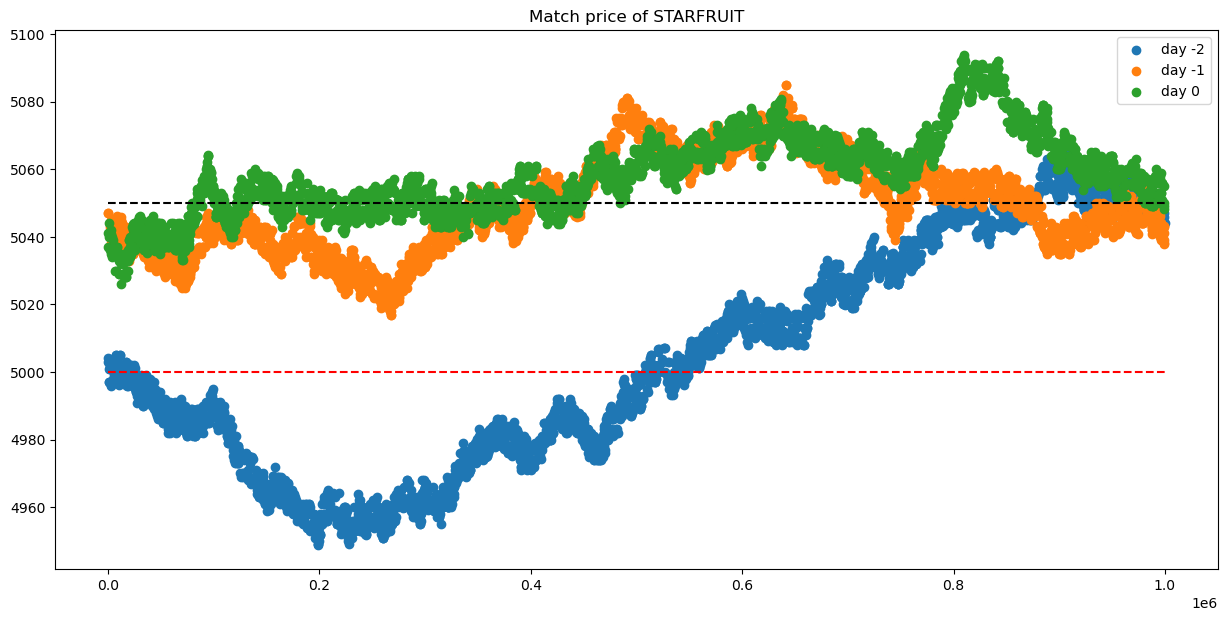

In [8]:
plot_trade_matches('STARFRUIT', 0.05)

In [9]:
# Buy when fair price is below 5_000 as it appears that the price will go up?

In [10]:
# Use past 100 timestamps as predictors for fair price in next timestamp
# Average the price if multiple trades occurred at same timestamp

In [11]:
p = 4 # number of aggregated match prices, and number of mid prices (2p predictors in model)

def getDesignResponseAndTimestamp(product, day):
    tradesAvg_df = trades_df_byDay[day][lambda df: df['symbol'] == product]
    tradesAvg_df = tradesAvg_df.groupby(['timestamp'], as_index=False).mean()
    
    prices_df = prices_df_byDay[day][lambda df: df['product'] == product]
    
    n = (1_000_000 // 100) - p
    
    X = [] # design matrix
    y = [] # response vector
    
    timestamps = []

    for i in range(n):
        timestamp = (i + p) * 100
        match_prices = tradesAvg_df[lambda df: df['timestamp'] < timestamp]['price']
        
        if match_prices.shape[0] < p:
            continue
        
        predictors_match_price = match_prices.iloc[-p:].values
        predictors_mid_price = prices_df[lambda df: df['timestamp'] < timestamp]['mid_price'][-p:].values
        
        future_match_prices = tradesAvg_df[lambda df: df['timestamp'] >= timestamp]
        
        if future_match_prices.shape[0] == 0:
            continue
        
        response_match_price = future_match_prices.iloc[0]['price']
        response_mid_price = prices_df.iloc[i+p]['mid_price']
        
        X.append(np.concatenate((
            predictors_match_price,
            predictors_mid_price
        )))
        
        # TODO try just with match
        y.append(response_mid_price)
        timestamps.append(timestamp)

    X = np.array(X)
    y = np.array(y)
    
    return X, y, timestamps

In [12]:
X, y, timestamp = getDesignResponseAndTimestamp('STARFRUIT', -1)

print(f"{X.shape[0]} training observations")

C:\Users\joshu\AppData\Local\Temp\ipykernel_19352\1567113033.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tradesAvg_df = tradesAvg_df.groupby(['timestamp'], as_index=False).mean()


9971 training observations


In [13]:
lm_model = LinearRegression()
lm_model.fit(X, y)

lm_model.intercept_, lm_model.coef_

(10.225393289480053,
 array([ 0.03107961,  0.02903863,  0.01177898, -0.00727152,  0.15128262,
         0.20560836,  0.24910466,  0.32736096]))

Residual mean = -7.574409791918961e-13, std = 1.4021782517184154


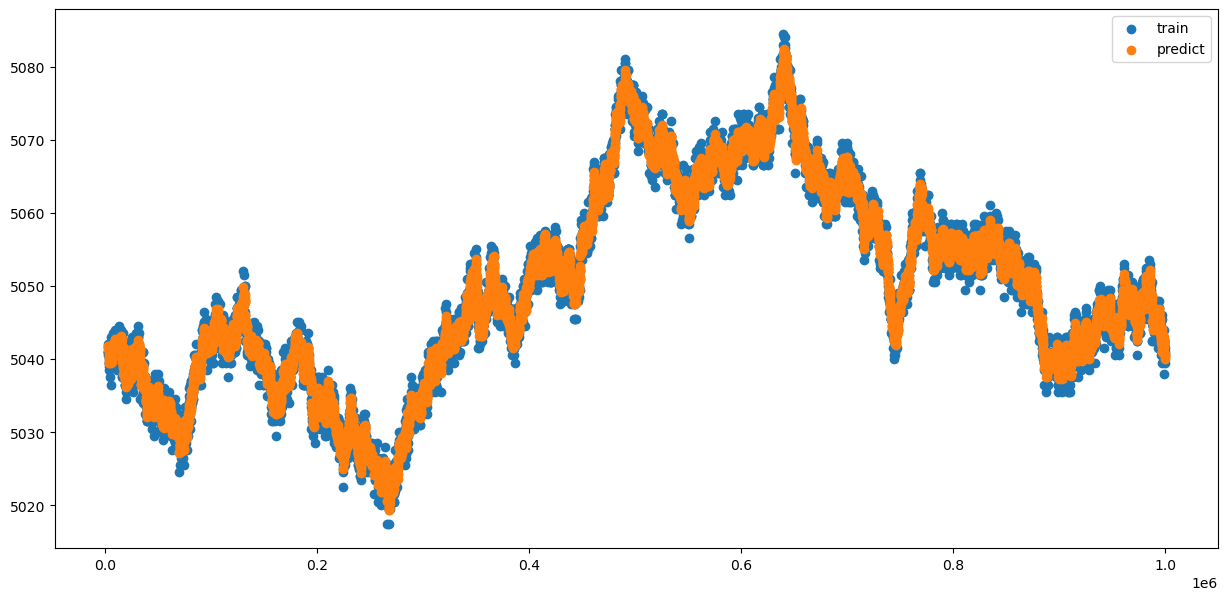

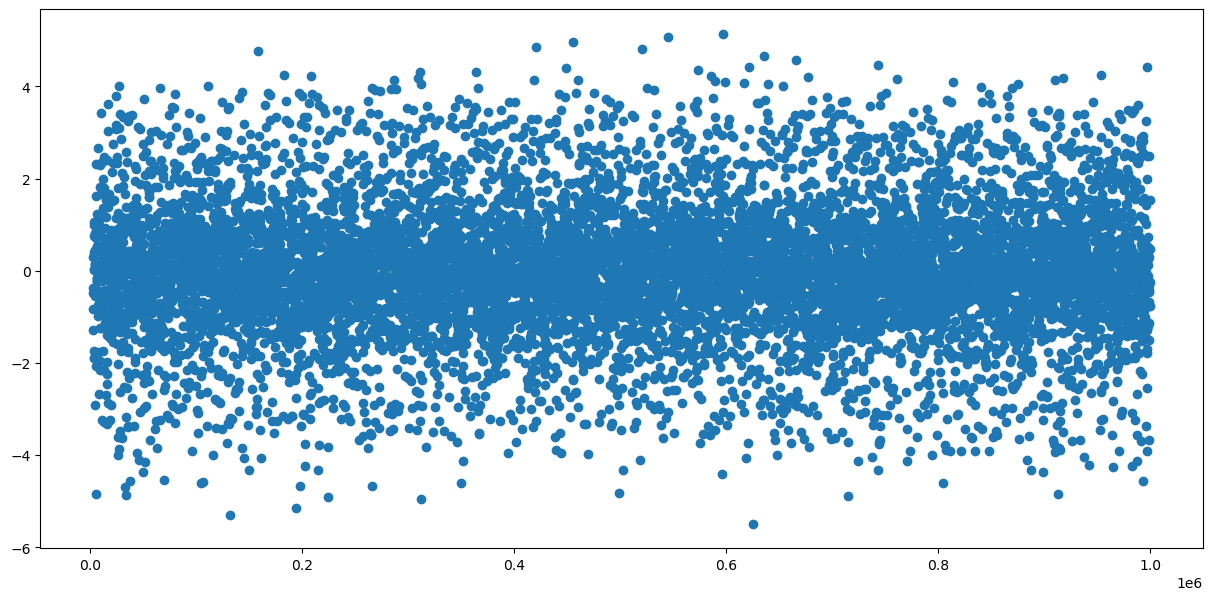

In [14]:
# Trained on STARFRUIT day -1

fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(timestamp, y)
ax.scatter(timestamp, lm_model.predict(X))
ax.legend(['train', 'predict'])
residuals = y - lm_model.predict(X)
print(f"Residual mean = {residuals.mean()}, std = {residuals.std()}")

fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(timestamp, residuals)

C:\Users\joshu\AppData\Local\Temp\ipykernel_19352\1567113033.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tradesAvg_df = tradesAvg_df.groupby(['timestamp'], as_index=False).mean()


Residual mean = -0.07723988697026625, std = 1.4135978872983126


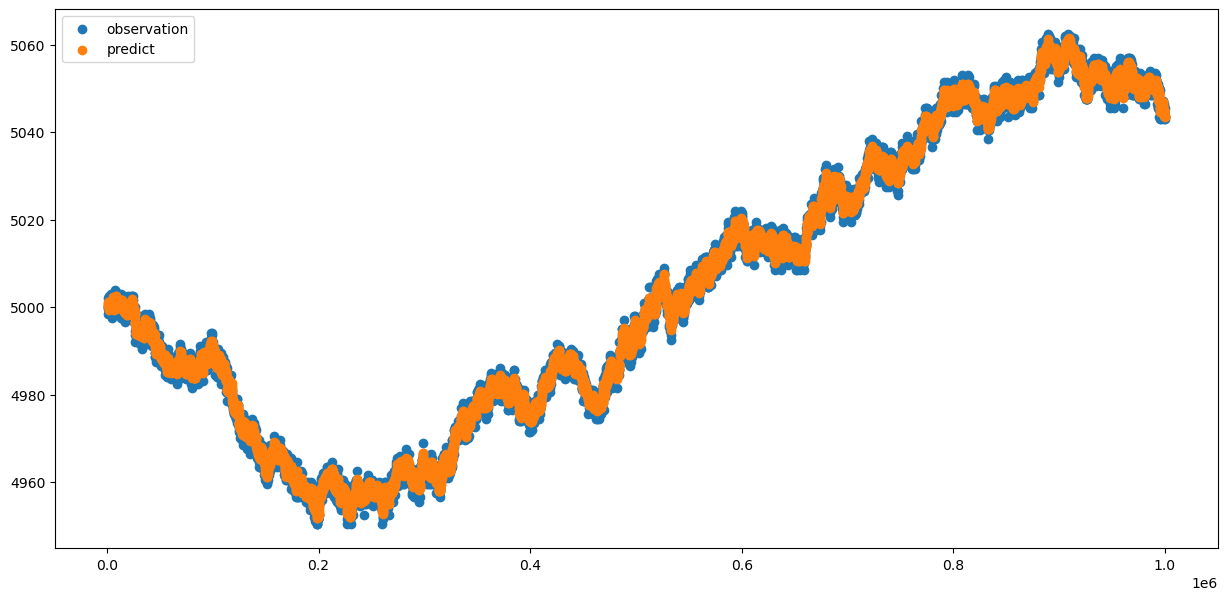

In [15]:
# Testing on STARFRUIT day -2

X, y, timestamp = getDesignResponseAndTimestamp('STARFRUIT', -2)
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(timestamp, y)
ax.scatter(timestamp, lm_model.predict(X))
ax.legend(['observation', 'predict'])
residuals = y - lm_model.predict(X)
print(f"Residual mean = {residuals.mean()}, std = {residuals.std()}")

# lm_model = LinearRegression()
# lm_model.fit(X, y)

# lm_model.coef_, lm_model.intercept_

C:\Users\joshu\AppData\Local\Temp\ipykernel_19352\1567113033.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tradesAvg_df = tradesAvg_df.groupby(['timestamp'], as_index=False).mean()


Residual mean = 0.010354824620473706, std = 1.3962308249260291


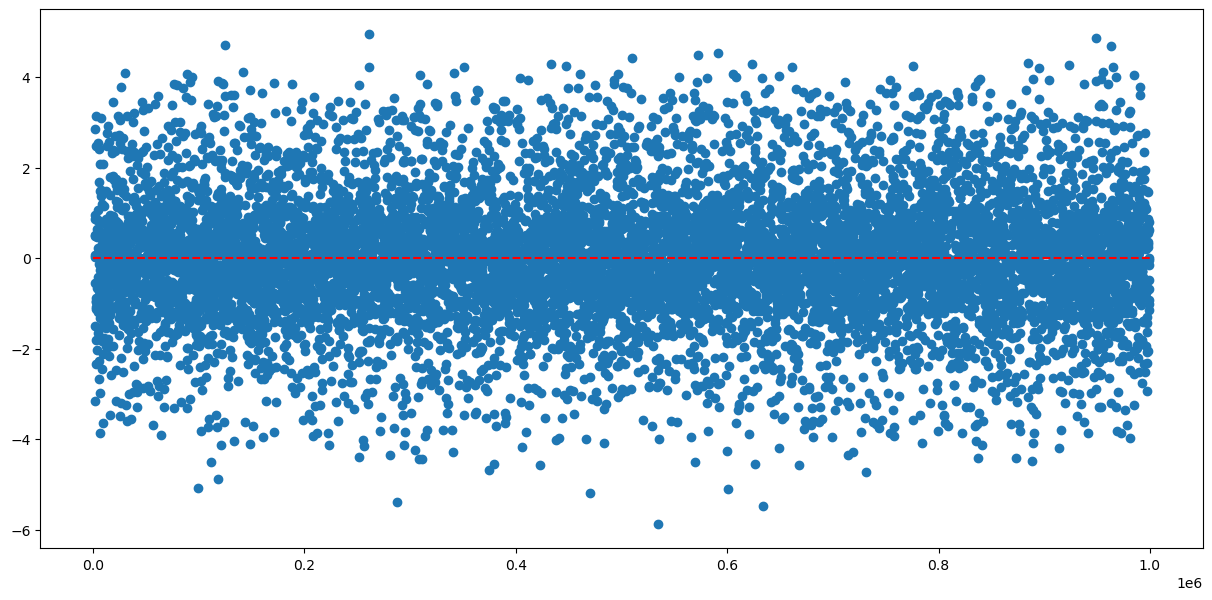

In [16]:
# Testing on STARFRUIT day 0

X, y, timestamp = getDesignResponseAndTimestamp('STARFRUIT', 0)
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(timestamp, y - lm_model.predict(X))
ax.plot(np.linspace(0, 1_000_000, 2), np.full(2, np.mean(y - lm_model.predict(X))), linestyle='--', c='r')
residuals = y - lm_model.predict(X)
print(f"Residual mean = {residuals.mean()}, std = {residuals.std()}")

# lm_model = LinearRegression()
# lm_model.fit(X, y)

# lm_model.coef_, lm_model.intercept_

In [17]:
X_2, y_2, timestamp = getDesignResponseAndTimestamp('STARFRUIT', -2)
X_1, y_1, timestamp = getDesignResponseAndTimestamp('STARFRUIT', -1)
X_0, y_0, timestamp = getDesignResponseAndTimestamp('STARFRUIT', 0)

X_combined = np.concatenate((X_2, X_1, X_0))
y_combined = np.concatenate((y_2, y_1, y_0))

C:\Users\joshu\AppData\Local\Temp\ipykernel_19352\1567113033.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tradesAvg_df = tradesAvg_df.groupby(['timestamp'], as_index=False).mean()
C:\Users\joshu\AppData\Local\Temp\ipykernel_19352\1567113033.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tradesAvg_df = tradesAvg_df.groupby(['timestamp'], as_index=False).mean()
C:\Users\joshu\AppData\Local\Temp\ipykernel_19352\1567113033.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only

In [18]:
# to_convert_to_df = np.concatenate((X_combined, y_combined[..., np.newaxis]), axis=1)
# df_to_run_regression_with = pd.DataFrame(data=to_convert_to_df, columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'y'])
# df_to_run_regression_with.to_csv('../csv/joseph_regression.csv', index=False)

In [19]:
from sklearn.linear_model import LassoCV

lasso_model = LassoCV(max_iter=10_000, n_jobs=-1)

lasso_model.fit(X_combined, y_combined)

lasso_model.intercept_, lasso_model.coef_

(7.749335252087803,
 array([0.02684371, 0.02403479, 0.01530637, 0.        , 0.15538833,
        0.17927965, 0.25631409, 0.34130254]))

In [20]:
from sklearn.linear_model import RidgeCV

ridge_model = RidgeCV(cv=10)

ridge_model.fit(X_combined, y_combined)

ridge_model.intercept_, ridge_model.coef_

(2.550748187895806,
 array([ 0.0250963 ,  0.0218832 ,  0.01218533, -0.00467649,  0.16835573,
         0.19286071,  0.25039088,  0.33340463]))